## YOLO + microsam prediction

Import Yolo and setup paths

In [48]:
import numpy as np
import napari
print("Napari version:", napari.__version__)
from pathlib import Path
from segment_everything.weights_helper import get_weights_path
from segment_everything.object_detectors.yolo_detector import YoloDetector

Napari version: 0.6.6


### Load test image

In [49]:
tnia_images_path = Path(r"D:\images")
tnia_images_path = Path(r"/home/bnorthan/images")
parent_path=Path(tnia_images_path / r'tnia-python-images/imagesc/2025_05_10_SOTA_Test_Set')

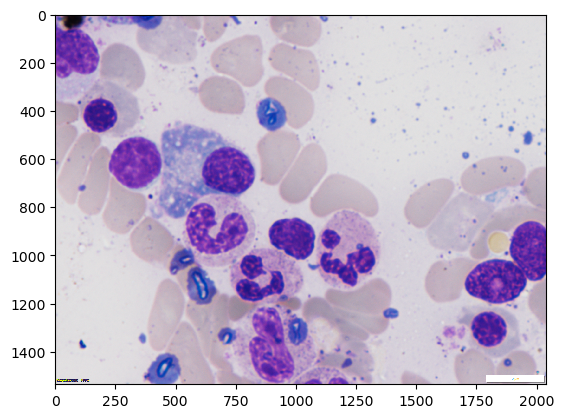

In [50]:
from skimage.io import imread
import matplotlib.pyplot as plt

img = imread(parent_path / r"TestHidden_005.bmp")

# create grayscale only for napari display (temporary napari bug with RGB + 3D labels)
img_grayscale = img.mean(axis=2).astype(np.uint8)

# show original image with matplotlib
plt.imshow(img)

### Detect Bounding Boxes with YOLO

Set up a bounding box detector.  Here I use a Yolo detector vendored from mobilesam, but any bounding box detector would work for this step. 

In [51]:
weights_path = str(get_weights_path("ObjectAwareModel"))
weights_path = str(get_weights_path("ObjectAwareModelHuggingFace"))
yolo_detector_object_aware = YoloDetector(weights_path, "ObjectAwareModelFromMobileSamV2", device='cuda')

Generate bounding boxes with YOLO

In [52]:
results = yolo_detector_object_aware.get_results(img, conf=0.2, imgsz=2048)


0: 1568x2048 106 objects, 212.8ms
Speed: 11.3ms preprocess, 212.8ms inference, 1.1ms postprocess per image at shape (1, 3, 2048, 2048)


Get the classes and the bounding boxes from the Yolo result.  Convert bbox to Napari and Microsam format. 


In [53]:
# Use YoloDetector helpers to get boxes in the desired formats

bboxes_microsam = yolo_detector_object_aware.get_microsam_bboxes(img, conf=0.2, imgsz=2048)
boxes_napari = yolo_detector_object_aware.get_napari_bboxes(img, conf=0.2, imgsz=2048)

Predicting bounding boxes for image data


0: 1568x2048 106 objects, 213.2ms
Speed: 11.1ms preprocess, 213.2ms inference, 1.1ms postprocess per image at shape (1, 3, 2048, 2048)



Predicting bounding boxes for image data


0: 1568x2048 106 objects, 214.0ms
Speed: 10.0ms preprocess, 214.0ms inference, 1.1ms postprocess per image at shape (1, 3, 2048, 2048)


### Use microsam for mask generation

In [54]:
from segment_everything.stacked_labels import StackedLabels
from segment_everything.mask_detectors.microsam import microsam_detector

detector = microsam_detector(model_type="vit_b_lm", device='cpu')
detector.set_image(img)
mask_list = detector.segment_boxes(bboxes_microsam)


Compute Image Embeddings 2D: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


### Use StackedLabels to make label images

In [55]:
stacked_labels = StackedLabels(mask_list)
labels = stacked_labels.make_3d_labels()


In [56]:
viewer = napari.Viewer()
viewer.add_image(img_grayscale, name='image')
viewer.add_labels(labels, name='labels', scale=(3,1,1))

<Labels layer 'labels' at 0x769f54a30850>

### Send bounding boxes to Napari

In [57]:
shapes_layer = viewer.add_shapes(name='bboxes', face_color= 'transparent', edge_color='green', edge_width=3)

for bbox_microsam in boxes_napari:
    shapes_layer.add_rectangles([bbox_microsam])

### Use StackedLabels to make 2D label image

... and visualize with skimage

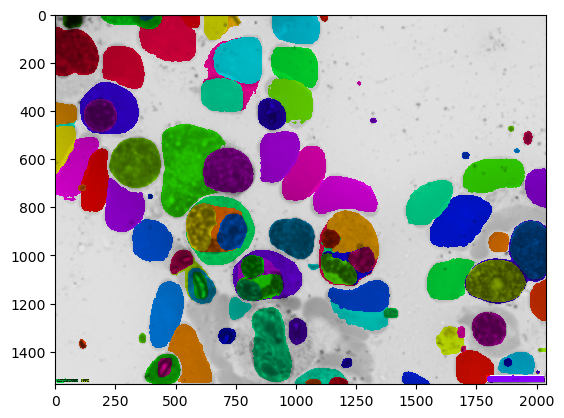

In [58]:
from tnia.plotting.plt_helper import mask_overlay


test = stacked_labels.make_2d_labels(type="max")

plt.imshow(mask_overlay(img, test))

### Add slice to 3D labels

This is useful to add a new label instance to the 3D labels

In [59]:
# append empty zero slice to labels 

temp = np.zeros((1, viewer.layers['labels'].data.shape[1], viewer.layers['labels'].data.shape[2]))
temp = temp.astype(viewer.layers['labels'].data.dtype)

viewer.layers['labels'].data = np.concatenate([viewer.layers['labels'].data, temp], axis=0)
